# Wordle GRPO Data Exploration

This notebook explores the Wordle GRPO datasets and helps understand:
- Dataset structure and format
- Expected input/output formats for the model
- How reward functions work on real examples
- Word list statistics and patterns
- What the model needs to learn

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

print(f"Project root: {project_root}")

Project root: /Users/alexchilton/Downloads/Current_Learning/uni/BERN/module4_transformer_grpo/transformer_grpo/wordle-grpo


In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import json

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


## 1. Load Datasets

We'll load both the GRPO training dataset and the SFT reference dataset.

In [4]:
from datasets import load_dataset

# Load datasets
data_dir = project_root / "data" / "cache"

print("Loading datasets...")
print("This may take a moment on first run...\n")

try:
    grpo_dataset = load_dataset(
        "predibase/wordle-grpo",
        cache_dir=str(data_dir),
        download_mode="reuse_dataset_if_exists"
    )
    print("✓ GRPO dataset loaded")
except Exception as e:
    print(f"✗ Error loading GRPO dataset: {e}")
    print("Run: python scripts/download_data.py")
    grpo_dataset = None

try:
    sft_dataset = load_dataset(
        "predibase/wordle-sft",
        cache_dir=str(data_dir),
        download_mode="reuse_dataset_if_exists"
    )
    print("✓ SFT dataset loaded")
except Exception as e:
    print(f"✗ Error loading SFT dataset: {e}")
    print("Run: python scripts/download_data.py")
    sft_dataset = None

Loading datasets...
This may take a moment on first run...

✓ GRPO dataset loaded
✓ SFT dataset loaded


## 2. Dataset Overview

Let's examine the structure of our datasets.

In [5]:
if grpo_dataset:
    print("=" * 60)
    print("GRPO Dataset Structure")
    print("=" * 60)
    print(f"Splits: {list(grpo_dataset.keys())}")
    print()
    
    for split_name, split_data in grpo_dataset.items():
        print(f"{split_name.upper()}:")
        print(f"  Size: {len(split_data)} examples")
        print(f"  Columns: {split_data.column_names}")
        print()

GRPO Dataset Structure
Splits: ['train']

TRAIN:
  Size: 76 examples
  Columns: ['prompt', 'word_list', 'past_guess_history', 'secret']



In [6]:
if sft_dataset:
    print("=" * 60)
    print("SFT Dataset Structure")
    print("=" * 60)
    print(f"Splits: {list(sft_dataset.keys())}")
    print()
    
    for split_name, split_data in sft_dataset.items():
        print(f"{split_name.upper()}:")
        print(f"  Size: {len(split_data)} examples")
        print(f"  Columns: {split_data.column_names}")
        print()

SFT Dataset Structure
Splits: ['train']

TRAIN:
  Size: 82 examples
  Columns: ['prompt', 'completion']



## 3. Sample Examples

Let's look at actual examples to understand the data format.

In [7]:
if grpo_dataset:
    # Get first split
    split_name = list(grpo_dataset.keys())[0]
    split_data = grpo_dataset[split_name]
    
    print("=" * 60)
    print(f"Sample Example from GRPO Dataset ({split_name} split)")
    print("=" * 60)
    
    example = split_data[0]
    
    for key, value in example.items():
        print(f"\n{key}:")
        print("-" * 40)
        
        # Pretty print based on type
        if isinstance(value, str):
            # Truncate long strings
            if len(value) > 500:
                print(value[:500] + "\n... (truncated)")
            else:
                print(value)
        elif isinstance(value, (list, dict)):
            print(json.dumps(value, indent=2))
        else:
            print(value)

Sample Example from GRPO Dataset (train split)

prompt:
----------------------------------------
<|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a valid **5-letter English word**.
- After each guess, you will receive feedback indicating how close your guess was.

### Feedback Format:
Each letter in your guess will receive one of three symbols:
1. ✓ : The letter is in the word and in the CORRECT position.
2. - : The letter is in the word but in the WRONG position.
3. x : The le
... (truncated)

word_list:
----------------------------------------
https://raw.githubusercontent.com/arnavgarg1/arnavgarg1/refs/heads/main/five_letter_words.csv

past_guess_history:
----------------------------------------
[]

secret:
----------------------------------------
ABHOR


### Examine Multiple Examples

Let's look at a few more examples to see the variation in the data.

In [8]:
if grpo_dataset:
    split_data = grpo_dataset[list(grpo_dataset.keys())[0]]
    
    # Show 3 examples
    for i in range(min(3, len(split_data))):
        example = split_data[i]
        
        print(f"\n{'=' * 60}")
        print(f"Example {i+1}")
        print("=" * 60)
        
        # Show key information
        if 'prompt' in example:
            prompt_preview = example['prompt'][:200] if len(example['prompt']) > 200 else example['prompt']
            print(f"Prompt (preview): {prompt_preview}...")
            print()
        
        if 'past_guess_history' in example:
            print(f"Past guess history: {example['past_guess_history']}")
            print()
        
        if 'word_list' in example:
            word_list = example['word_list']
            if isinstance(word_list, list):
                print(f"Word list size: {len(word_list)}")
                print(f"Sample words: {word_list[:10]}")
            else:
                print(f"Word list: {word_list}")
            print()


Example 1
Prompt (preview): <|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a valid **5-letter English word**.
-...

Past guess history: []

Word list: https://raw.githubusercontent.com/arnavgarg1/arnavgarg1/refs/heads/main/five_letter_words.csv


Example 2
Prompt (preview): <|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a valid **5-letter English word**.
-...

Past guess history: [['CRANE', 'C(x) R(x) A(-) N(x) E(-)'], ['SWEAT', 'S(x) W(x) E(-) A(-) T(x)']]

Word list: https://raw.githubusercontent.com/arnavgarg1/arnavgarg1/refs/heads/main/five_letter_words.csv


Example 3
Prompt (preview): <|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a v

## 4. Analyze Past Guess History Structure

The `past_guess_history` contains previous guesses and their feedback. This is crucial for the model to learn from.

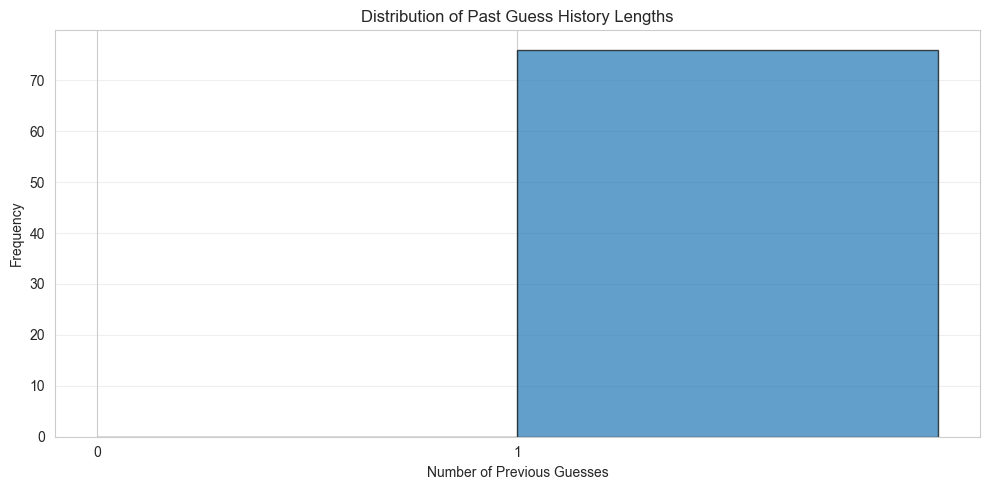

Statistics:
  Mean history length: 1.00
  Median history length: 1
  Max history length: 1
  Examples with no history: 0 (0.0%)


In [9]:
if grpo_dataset:
    split_data = grpo_dataset[list(grpo_dataset.keys())[0]]
    
    # Collect guess history statistics
    history_lengths = []
    
    for example in split_data:
        if 'past_guess_history' in example:
            history = example['past_guess_history']
            if isinstance(history, list):
                history_lengths.append(len(history))
            elif isinstance(history, str) and history:
                # Might be stored as string
                history_lengths.append(1)
            else:
                history_lengths.append(0)
    
    # Visualize distribution
    plt.figure(figsize=(10, 5))
    plt.hist(history_lengths, bins=range(0, max(history_lengths) + 2), alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Previous Guesses')
    plt.ylabel('Frequency')
    plt.title('Distribution of Past Guess History Lengths')
    plt.xticks(range(0, max(history_lengths) + 1))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Statistics:")
    print(f"  Mean history length: {np.mean(history_lengths):.2f}")
    print(f"  Median history length: {np.median(history_lengths):.0f}")
    print(f"  Max history length: {max(history_lengths)}")
    print(f"  Examples with no history: {history_lengths.count(0)} ({history_lengths.count(0)/len(history_lengths)*100:.1f}%)")

### Visualize Example Guess Histories

Let's look at the structure of actual guess histories.

In [10]:
if grpo_dataset:
    split_data = grpo_dataset[list(grpo_dataset.keys())[0]]
    
    # Find examples with different history lengths
    examples_by_length = defaultdict(list)
    
    for i, example in enumerate(split_data):
        if 'past_guess_history' in example:
            history = example['past_guess_history']
            length = len(history) if isinstance(history, list) else (1 if history else 0)
            examples_by_length[length].append(i)
    
    # Show examples with 0, 1, 2, 3 previous guesses
    for num_guesses in [0, 1, 2, 3]:
        if num_guesses in examples_by_length and examples_by_length[num_guesses]:
            idx = examples_by_length[num_guesses][0]
            example = split_data[idx]
            
            print(f"\n{'=' * 60}")
            print(f"Example with {num_guesses} previous guess(es)")
            print("=" * 60)
            
            if 'past_guess_history' in example:
                history = example['past_guess_history']
                print(f"History: {json.dumps(history, indent=2)}")
            
            if 'prompt' in example:
                prompt_preview = example['prompt'][:300]
                print(f"\nPrompt preview:\n{prompt_preview}...")


Example with 1 previous guess(es)
History: "[]"

Prompt preview:
<|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a valid **5-letter English word**.
- After each guess, you will receive feedback indicating how close your guess was.

### Feedback Form...


## 5. Test Reward Functions

Let's test our reward functions on real examples to understand how they work.

In [11]:
from training.reward_functions import (
    output_format_check,
    uses_previous_feedback,
    guess_value,
    CombinedReward
)

print("✓ Reward functions loaded")

✓ Reward functions loaded


### Test Output Format Check

This reward function checks if the output follows the correct format.

In [12]:
# Test different completion formats
test_cases = [
    {
        "name": "Perfect format",
        "completion": "<think>Let me try a common starting word</think>\n<guess>CRANE</guess>",
        "example": {"word_list": ["CRANE", "TRAIN", "BRAIN"]}
    },
    {
        "name": "Missing think tags",
        "completion": "<guess>CRANE</guess>",
        "example": {"word_list": ["CRANE", "TRAIN", "BRAIN"]}
    },
    {
        "name": "Invalid word (not in list)",
        "completion": "<think>Random guess</think>\n<guess>ZZZZZ</guess>",
        "example": {"word_list": ["CRANE", "TRAIN", "BRAIN"]}
    },
    {
        "name": "Wrong length",
        "completion": "<think>Too short</think>\n<guess>CAT</guess>",
        "example": {"word_list": ["CRANE", "TRAIN", "BRAIN"]}
    },
    {
        "name": "No tags at all",
        "completion": "I think CRANE is a good guess",
        "example": {"word_list": ["CRANE", "TRAIN", "BRAIN"]}
    },
]

print("=" * 60)
print("Testing Output Format Check")
print("=" * 60)

for test in test_cases:
    reward = output_format_check("", test["completion"], test["example"])
    print(f"\n{test['name']}:")
    print(f"  Completion: {test['completion'][:60]}...")
    print(f"  Reward: {reward:.2f}")

Testing Output Format Check

Perfect format:
  Completion: <think>Let me try a common starting word</think>
<guess>CRAN...
  Reward: 0.00

Missing think tags:
  Completion: <guess>CRANE</guess>...
  Reward: 0.00

Invalid word (not in list):
  Completion: <think>Random guess</think>
<guess>ZZZZZ</guess>...
  Reward: 0.00

Wrong length:
  Completion: <think>Too short</think>
<guess>CAT</guess>...
  Reward: 0.00

No tags at all:
  Completion: I think CRANE is a good guess...
  Reward: 0.00


### Test Uses Previous Feedback

This reward function checks if the model uses information from previous guesses.

In [13]:
# Test with different guess scenarios
test_cases_feedback = [
    {
        "name": "Keeps correct letter in position",
        "completion": "<think>A was correct</think>\n<guess>BRAIN</guess>",
        "example": {
            "past_guess_history": [
                {"guess": "TRAIN", "feedback": "T(-) R(✓) A(✓) I(x) N(x)"}
            ],
            "word_list": ["CRANE", "BRAIN", "GRAIN"]
        }
    },
    {
        "name": "Uses wrong letter again (penalty)",
        "completion": "<think>Trying again</think>\n<guess>TRAIN</guess>",
        "example": {
            "past_guess_history": [
                {"guess": "STAIN", "feedback": "S(x) T(x) A(✓) I(x) N(x)"}
            ],
            "word_list": ["CRANE", "BRAIN", "GRAIN"]
        }
    },
    {
        "name": "Tries misplaced letter in new position",
        "completion": "<think>R was in wrong spot</think>\n<guess>SIREN</guess>",
        "example": {
            "past_guess_history": [
                {"guess": "TRAIN", "feedback": "T(x) R(-) A(x) I(x) N(x)"}
            ],
            "word_list": ["SIREN", "AFIRE", "BORED"]
        }
    },
    {
        "name": "First guess (no history)",
        "completion": "<think>Starting word</think>\n<guess>CRANE</guess>",
        "example": {
            "past_guess_history": [],
            "word_list": ["CRANE", "BRAIN", "GRAIN"]
        }
    },
]

print("=" * 60)
print("Testing Uses Previous Feedback")
print("=" * 60)

for test in test_cases_feedback:
    reward = uses_previous_feedback("", test["completion"], test["example"])
    print(f"\n{test['name']}:")
    if test['example']['past_guess_history']:
        print(f"  Previous: {test['example']['past_guess_history'][0]}")
    print(f"  New guess: {test['completion'][test['completion'].find('<guess>')+7:test['completion'].find('</guess>')]}")
    print(f"  Reward: {reward:.2f}")

Testing Uses Previous Feedback

Keeps correct letter in position:
  Previous: {'guess': 'TRAIN', 'feedback': 'T(-) R(✓) A(✓) I(x) N(x)'}
  New guess: BRAIN
  Reward: 0.25

Uses wrong letter again (penalty):
  Previous: {'guess': 'STAIN', 'feedback': 'S(x) T(x) A(✓) I(x) N(x)'}
  New guess: TRAIN
  Reward: 0.25

Tries misplaced letter in new position:
  Previous: {'guess': 'TRAIN', 'feedback': 'T(x) R(-) A(x) I(x) N(x)'}
  New guess: SIREN
  Reward: 0.25

First guess (no history):
  New guess: CRANE
  Reward: 0.10


### Test Guess Value (Information Gain)

This reward function measures how much information a guess provides.

In [14]:
# Test with different word lists and guesses
test_cases_value = [
    {
        "name": "Good starting word (high entropy)",
        "completion": "<think>CRANE has common letters</think>\n<guess>CRANE</guess>",
        "example": {
            "word_list": ["CRANE", "BRAIN", "GRAIN", "DRAIN", "TRAIN", "PLAIN", "SLAIN"]
        }
    },
    {
        "name": "Repeated letters (lower entropy)",
        "completion": "<think>Trying GEESE</think>\n<guess>GEESE</guess>",
        "example": {
            "word_list": ["CRANE", "BRAIN", "GRAIN", "DRAIN", "TRAIN", "PLAIN", "SLAIN"]
        }
    },
    {
        "name": "Uncommon letters",
        "completion": "<think>Testing Q and Z</think>\n<guess>QUIZZ</guess>",
        "example": {
            "word_list": ["CRANE", "BRAIN", "GRAIN", "DRAIN", "TRAIN", "PLAIN", "SLAIN"]
        }
    },
]

print("=" * 60)
print("Testing Guess Value (Information Gain)")
print("=" * 60)

for test in test_cases_value:
    reward = guess_value("", test["completion"], test["example"])
    print(f"\n{test['name']}:")
    guess = test['completion'][test['completion'].find('<guess>')+7:test['completion'].find('</guess>')]
    print(f"  Guess: {guess}")
    print(f"  Word list size: {len(test['example']['word_list'])}")
    print(f"  Reward: {reward:.3f}")

Testing Guess Value (Information Gain)

Good starting word (high entropy):
  Guess: CRANE
  Word list size: 7
  Reward: 0.491

Repeated letters (lower entropy):
  Guess: GEESE
  Word list size: 7
  Reward: 0.000

Uncommon letters:
  Guess: QUIZZ
  Word list size: 7
  Reward: 0.000


### Test Combined Reward

In practice, we combine all three reward functions.

In [15]:
combined_reward = CombinedReward(
    format_weight=1.0,
    feedback_weight=0.5,
    value_weight=0.3
)

# Test on a few examples
test_cases_combined = [
    {
        "name": "Perfect guess",
        "completion": "<think>Keeping R and A in correct positions</think>\n<guess>GRAIN</guess>",
        "example": {
            "past_guess_history": [
                {"guess": "TRAIN", "feedback": "T(x) R(✓) A(✓) I(x) N(x)"}
            ],
            "word_list": ["CRANE", "BRAIN", "GRAIN", "DRAIN"]
        }
    },
    {
        "name": "Bad format",
        "completion": "I think GRAIN",
        "example": {
            "past_guess_history": [
                {"guess": "TRAIN", "feedback": "T(x) R(✓) A(✓) I(x) N(x)"}
            ],
            "word_list": ["CRANE", "BRAIN", "GRAIN", "DRAIN"]
        }
    },
]

print("=" * 60)
print("Testing Combined Reward")
print("=" * 60)
print(f"Weights: format={combined_reward.format_weight}, "
      f"feedback={combined_reward.feedback_weight}, "
      f"value={combined_reward.value_weight}\n")

for test in test_cases_combined:
    total_reward = combined_reward("", test["completion"], test["example"])
    
    # Also show individual components
    format_r = output_format_check("", test["completion"], test["example"])
    feedback_r = uses_previous_feedback("", test["completion"], test["example"])
    value_r = guess_value("", test["completion"], test["example"])
    
    print(f"\n{test['name']}:")
    print(f"  Completion: {test['completion'][:60]}...")
    print(f"  Format reward: {format_r:.2f}")
    print(f"  Feedback reward: {feedback_r:.2f}")
    print(f"  Value reward: {value_r:.3f}")
    print(f"  TOTAL REWARD: {total_reward:.3f}")

Testing Combined Reward
Weights: format=1.0, feedback=0.5, value=0.3


Perfect guess:
  Completion: <think>Keeping R and A in correct positions</think>
<guess>G...
  Format reward: 0.00
  Feedback reward: 0.25
  Value reward: 0.000
  TOTAL REWARD: 0.125

Bad format:
  Completion: I think GRAIN...
  Format reward: 0.00
  Feedback reward: 0.00
  Value reward: 0.000
  TOTAL REWARD: 0.000


## 6. Word List Analysis

Let's analyze the word lists to understand what words the model needs to work with.

In [16]:
# Extract all unique words from dataset
all_words = set()

if grpo_dataset:
    for split_name, split_data in grpo_dataset.items():
        for example in split_data:
            if 'word_list' in example and isinstance(example['word_list'], list):
                all_words.update(example['word_list'])

print(f"Total unique words: {len(all_words)}")
print(f"Sample words: {list(all_words)[:20]}")

Total unique words: 0
Sample words: []


### Letter Frequency Analysis

In [17]:
if all_words:
    # Count letter frequencies
    letter_counts = Counter()
    position_counts = [Counter() for _ in range(5)]
    
    for word in all_words:
        for i, letter in enumerate(word.upper()):
            letter_counts[letter] += 1
            if i < 5:
                position_counts[i][letter] += 1
    
    # Plot overall letter frequency
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    letters, counts = zip(*letter_counts.most_common())
    plt.bar(letters, counts, alpha=0.7, edgecolor='black')
    plt.xlabel('Letter')
    plt.ylabel('Frequency')
    plt.title('Overall Letter Frequency in Word List')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    
    # Plot position-specific frequency for common letters
    plt.subplot(1, 2, 2)
    top_letters = [l for l, _ in letter_counts.most_common(10)]
    
    position_data = []
    for letter in top_letters:
        position_data.append([position_counts[i][letter] for i in range(5)])
    
    x = np.arange(5)
    width = 0.08
    
    for i, letter in enumerate(top_letters):
        offset = width * (i - len(top_letters)/2)
        plt.bar(x + offset, position_data[i], width, label=letter, alpha=0.8)
    
    plt.xlabel('Position')
    plt.ylabel('Frequency')
    plt.title('Top 10 Letters by Position')
    plt.xticks(x, ['1st', '2nd', '3rd', '4th', '5th'])
    plt.legend(ncol=2)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nMost common letters:")
    for letter, count in letter_counts.most_common(10):
        print(f"  {letter}: {count}")

### Common Starting Letters

In [18]:
if all_words:
    # Analyze first letters
    first_letters = Counter(word[0] for word in all_words if len(word) >= 5)
    
    plt.figure(figsize=(12, 5))
    letters, counts = zip(*sorted(first_letters.items()))
    plt.bar(letters, counts, alpha=0.7, edgecolor='black', color='steelblue')
    plt.xlabel('First Letter')
    plt.ylabel('Number of Words')
    plt.title('Distribution of First Letters')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nMost common starting letters:")
    for letter, count in first_letters.most_common(10):
        print(f"  {letter}: {count}")

### Vowel vs Consonant Analysis

In [ ]:
if all_words:
    vowels = set('AEIOU')
    
    # Count vowels per word
    vowel_counts = Counter()
    for word in all_words:
        num_vowels = sum(1 for letter in word.upper() if letter in vowels)
        vowel_counts[num_vowels] += 1
    
    plt.figure(figsize=(10, 5))
    counts_list = [vowel_counts[i] for i in range(6)]
    plt.bar(range(6), counts_list, alpha=0.7, edgecolor='black', color='coral')
    plt.xlabel('Number of Vowels')
    plt.ylabel('Number of Words')
    plt.title('Distribution of Vowel Count in Words')
    plt.xticks(range(6))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nVowel distribution:")
    for num_vowels in range(6):
        count = vowel_counts[num_vowels]
        pct = count / len(all_words) * 100
        print(f"  {num_vowels} vowels: {count} words ({pct:.1f}%)")

## 7. What the Model Needs to Learn

Based on our exploration, here's what the model needs to learn:

### 1. **Output Format**
- Always use `<think>...</think><guess>...</guess>` tags
- Guess must be exactly 5 letters
- Guess must be from the valid word list

### 2. **Using Feedback**
- Keep letters marked as correct (✓) in the same position
- Try misplaced letters (-) in different positions
- Avoid letters marked as wrong (x)
- Explore new letters when appropriate

### 3. **Strategic Guessing**
- Choose words that maximize information gain
- Use common letters in starting guesses
- Consider letter frequency and position
- Balance exploration vs exploitation

### 4. **Game State Understanding**
- Track what's been guessed before
- Narrow down possibilities based on feedback
- Make logical deductions from constraints

Let's visualize the learning objective:

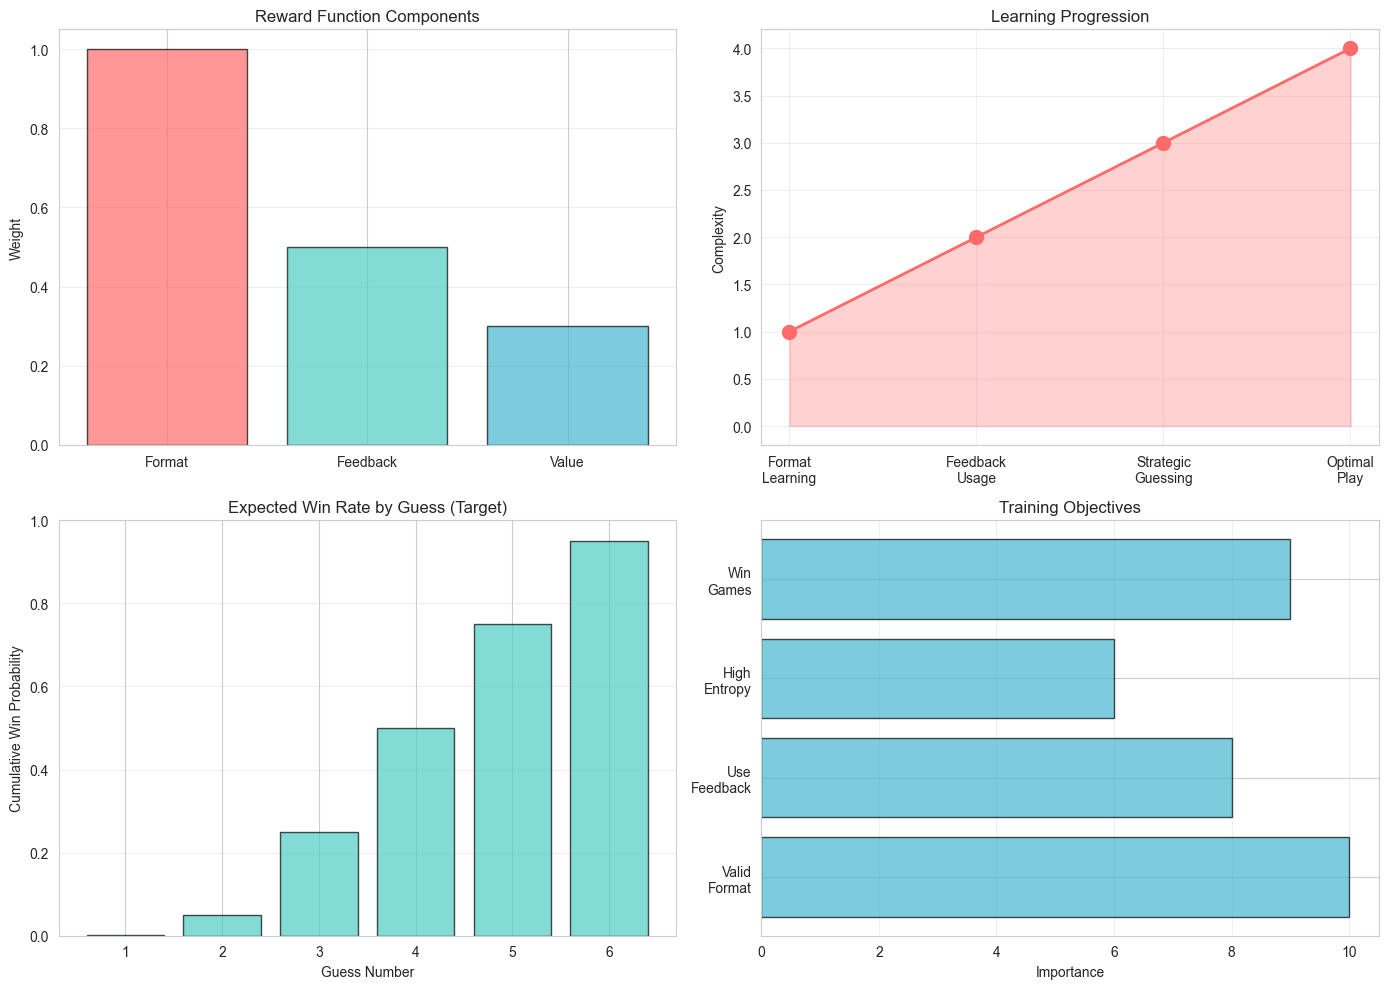


KEY INSIGHTS

1. The model must first learn valid output format (strict requirement)
2. Then learn to use feedback from previous guesses
3. Finally optimize for information gain (entropy)
4. Success = combining all three objectives



In [19]:
# Create a summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Reward components
ax = axes[0, 0]
components = ['Format', 'Feedback', 'Value']
weights = [1.0, 0.5, 0.3]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
ax.bar(components, weights, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Weight')
ax.set_title('Reward Function Components')
ax.grid(axis='y', alpha=0.3)

# 2. Learning progression
ax = axes[0, 1]
stages = ['Format\nLearning', 'Feedback\nUsage', 'Strategic\nGuessing', 'Optimal\nPlay']
difficulty = [1, 2, 3, 4]
ax.plot(stages, difficulty, marker='o', linewidth=2, markersize=10, color='#FF6B6B')
ax.fill_between(range(len(stages)), difficulty, alpha=0.3, color='#FF6B6B')
ax.set_ylabel('Complexity')
ax.set_title('Learning Progression')
ax.grid(alpha=0.3)

# 3. Expected win rate by guess number
ax = axes[1, 0]
guess_numbers = [1, 2, 3, 4, 5, 6]
# Rough estimates for visualization
expected_wins = [0.001, 0.05, 0.25, 0.50, 0.75, 0.95]
ax.bar(guess_numbers, expected_wins, alpha=0.7, color='#4ECDC4', edgecolor='black')
ax.set_xlabel('Guess Number')
ax.set_ylabel('Cumulative Win Probability')
ax.set_title('Expected Win Rate by Guess (Target)')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# 4. Training objectives
ax = axes[1, 1]
objectives = ['Valid\nFormat', 'Use\nFeedback', 'High\nEntropy', 'Win\nGames']
importance = [10, 8, 6, 9]
ax.barh(objectives, importance, alpha=0.7, color='#45B7D1', edgecolor='black')
ax.set_xlabel('Importance')
ax.set_title('Training Objectives')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)
print("\n1. The model must first learn valid output format (strict requirement)")
print("2. Then learn to use feedback from previous guesses")
print("3. Finally optimize for information gain (entropy)")
print("4. Success = combining all three objectives")
print("\n" + "=" * 60)

## 8. Summary Statistics

Let's compile final summary statistics about our datasets.

In [20]:
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)

if grpo_dataset:
    print("\nGRPO Dataset:")
    total_examples = sum(len(split) for split in grpo_dataset.values())
    print(f"  Total examples: {total_examples}")
    for split_name, split_data in grpo_dataset.items():
        print(f"  {split_name}: {len(split_data)}")

if sft_dataset:
    print("\nSFT Dataset:")
    total_examples = sum(len(split) for split in sft_dataset.values())
    print(f"  Total examples: {total_examples}")
    for split_name, split_data in sft_dataset.items():
        print(f"  {split_name}: {len(split_data)}")

if all_words:
    print("\nWord List:")
    print(f"  Unique words: {len(all_words)}")
    print(f"  Letter frequency (top 5): {', '.join([f'{l}:{c}' for l, c in letter_counts.most_common(5)])}")

print("\nReward Functions:")
print("  1. output_format_check: 0.0 to 1.0")
print("  2. uses_previous_feedback: variable (can be negative)")
print("  3. guess_value: 0.0 to 1.0 (normalized entropy)")

print("\n" + "=" * 60)
print("Ready for training!")
print("=" * 60)

DATASET SUMMARY

GRPO Dataset:
  Total examples: 76
  train: 76

SFT Dataset:
  Total examples: 82
  train: 82

Reward Functions:
  1. output_format_check: 0.0 to 1.0
  2. uses_previous_feedback: variable (can be negative)
  3. guess_value: 0.0 to 1.0 (normalized entropy)

Ready for training!


## Next Steps

Now that you understand the data:

1. **Run the setup test**: `python scripts/test_setup.py`
2. **Start training**: `python scripts/train.py --config configs/dev_config.yaml`
3. **Monitor rewards**: Watch how the three reward components improve
4. **Evaluate**: Test the trained model with `python scripts/evaluate.py`

The model should progressively learn:
- First: Valid format (reward ~1.0)
- Then: Using feedback (positive feedback rewards)
- Finally: Strategic guessing (high entropy rewards)